# LCLS cu_hxr from archived data

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from lcls_live.datamaps import get_datamaps
from lcls_live.archiver import lcls_archiver_restore

import os

In [4]:
BEAMPATH = 'cu_hxr'

## Datamaps, and all PVs needed

In [5]:
DM = get_datamaps(BEAMPATH)

DM.keys()

dict_keys(['collimators', 'subboosters', 'linac', 'K21_1', 'K21_2', 'K21_3', 'K21_4', 'K21_5', 'K21_6', 'K21_7', 'K21_8', 'K22_1', 'K22_2', 'K22_3', 'K22_4', 'K22_5', 'K22_6', 'K22_7', 'K22_8', 'K23_1', 'K23_2', 'K23_3', 'K23_4', 'K23_5', 'K23_6', 'K23_7', 'K23_8', 'K24_1', 'K24_2', 'K24_3', 'K24_4', 'K24_5', 'K24_6', 'K25_1', 'K25_2', 'K25_3', 'K25_4', 'K25_5', 'K25_6', 'K25_7', 'K25_8', 'K26_1', 'K26_2', 'K26_3', 'K26_4', 'K26_5', 'K26_6', 'K26_7', 'K26_8', 'K27_1', 'K27_2', 'K27_3', 'K27_4', 'K27_5', 'K27_6', 'K27_7', 'K27_8', 'K28_1', 'K28_2', 'K28_3', 'K28_4', 'K28_5', 'K28_6', 'K28_7', 'K28_8', 'K29_1', 'K29_2', 'K29_3', 'K29_4', 'K29_5', 'K29_6', 'K29_7', 'K29_8', 'K30_1', 'K30_2', 'K30_3', 'K30_4', 'K30_5', 'K30_6', 'K30_7', 'K30_8', 'quad', 'beginning_WS02', 'tao_energy_measurements'])

In [6]:
# datamaps to exclude
DENYLIST = ['beginning_WS02', 'quad']

In [7]:
# PVs needed
ALLPVS =  []
for name, dm in DM.items():
    if name in DENYLIST:
        continue
    ALLPVS.extend(dm.pvlist)
ALLPVS = list(set(ALLPVS))
len(ALLPVS)

554

## Archiver restore

In [8]:
ISOTIME = '2021-04-21T08:10:25.000000-07:00'

In [9]:
# Optional off-site setup

# Open an SSH tunnel in a terminal like:
# ssh -D 8080 <some user>@<some SLAC machine>

OFFSITE=True

if OFFSITE:
    os.environ['http_proxy']='socks5h://localhost:8080'
    os.environ['HTTPS_PROXY']='socks5h://localhost:8080'
    os.environ['ALL_PROXY']='socks5h://localhost:8080'

In [10]:
PVDATA = lcls_archiver_restore(ALLPVS, ISOTIME)

Requesting: http://lcls-archapp.slac.stanford.edu/retrieval/data/getDataAtTime?at=2021-04-21T08:10:25.000000-07:00&includeProxies=true


## Form commands using PVDATA and datamaps

In [11]:
CMDS = []
for name, dm in DM.items():
    CMDS.extend(dm.as_tao(PVDATA))

CMDS[0:5]

['set ele CE11 x1_limit = -0.001 * -4.427071416715884',
 'set ele CE11 x2_limit = 0.001 * 2.6004898727889953',
 'set ele SBST_21 phase_deg = 0.1586761474609375',
 'set ele SBST_22 phase_deg = -0.38561248779296875',
 'set ele SBST_23 phase_deg = -0.07339859008789062']

# Start Tao

In [12]:
from pytao import Tao

In [13]:
tao = Tao(f'-init $LCLS_LATTICE/bmad/models/{BEAMPATH}/tao.init -slice BEGINNING:ENDUNDH -noplot')

In [14]:
# apply commands all at once
tao.cmds(CMDS);

In [15]:
# Explicitly save beam 
tao.cmd('set beam saved_at = MARKER::*')
#tao.cmd('set beam saved_at = BEGUNDH,ENDUNDH')

[]

In [16]:
# Turn on CSR
tao.cmd(f'call $LCLS_LATTICE/bmad/models/{BEAMPATH}/scripts/Activate_CSR.tao');

In [17]:
# Turn on the beam
tao.cmd('set beam_init n_particle = 10000')

[]

In [18]:
#toggle on and off
tao.cmd('set global track_type = beam', raises=False) 


['1756 particle(s) lost at element 262: CE11  Total lost: 1756  of 10000',
 'Beam at Element: 1664. Time: 1 min',
 'Beam at Element: 1685. Time: 3 min',
 'Beam at Element: 1773. Time: 4 min',
 'Total number of lost particles by the end of universe  1:  1756.']

In [19]:
tao.cmd('set global track_type = single') 

[]

## Get particles 

In [20]:
from pmd_beamphysics import ParticleGroup

In [21]:
P = ParticleGroup(data=tao.bunch_data('ENDUNDH'))
# Select out live particles
P = P[P.status==1]

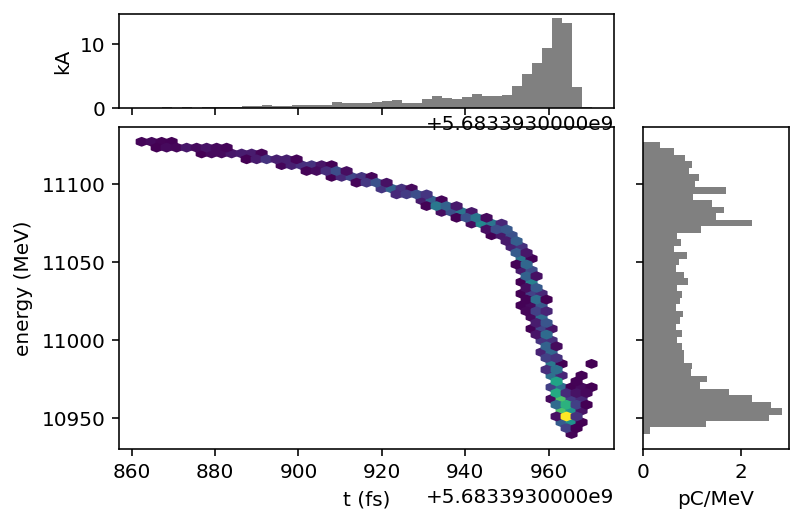

In [22]:
P.plot('t', 'energy')

In [23]:
# Make a function for this
def get_beam(ele):
    P = ParticleGroup(data=tao.bunch_data(ele))
    # Select out live particles
    P = P[P.status==1]    
    
    return P

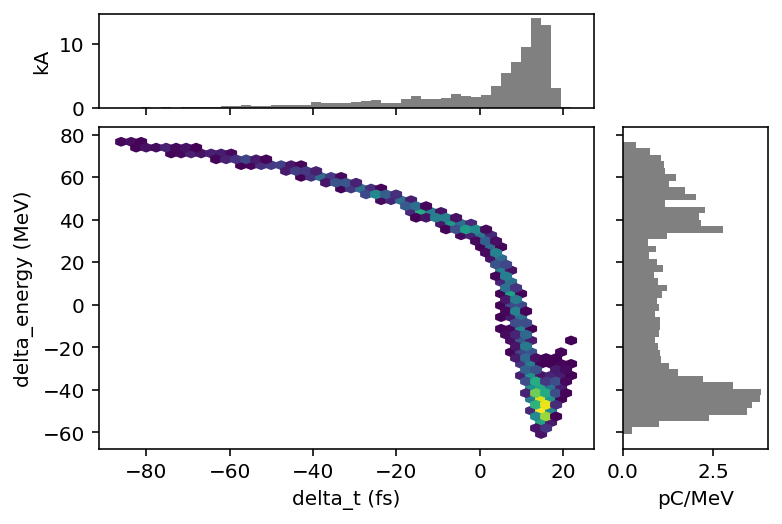

In [24]:
P1 = get_beam('BEGUNDH')
P1.plot('delta_t', 'delta_energy')

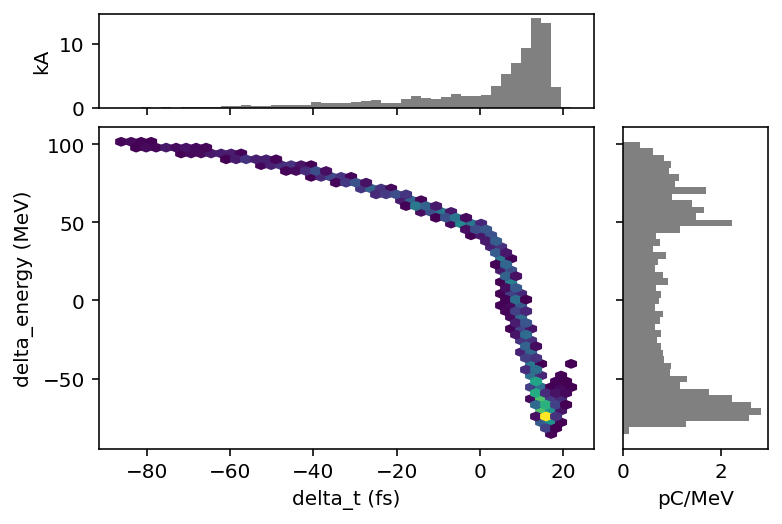

In [25]:
P2 = get_beam('ENDUNDH')
P2.plot('delta_t', 'delta_energy')

In [26]:
%%tao
sho beam 2823

-------------------------
Tao> sho beam 2823
Bunch parameters at: PSHXH45#1 (2823)
  Parameters for bunch:       1
  S-position:                   1.68066029E+03
  In branch:                  0
  Particles surviving:        8244
  Particles lost:             1756
  Particles lost (%):         17.560
  Charge live (C):              2.06100000E-10
  Centroid: -1.69643013E-04  6.34058913E-06  5.42791266E-08  7.84595721E-09 -2.94376804E-05 -2.61080887E-03
  RMS:       1.34962378E-04  7.38631761E-06  2.25209879E-05  2.00836027E-06  6.16081187E-06  3.71776573E-03

               norm_emitt            emit            beta           alpha
  a:         2.59754312E-06  1.20118818E-10  3.09917490E+01  1.97349057E+00
  b:         4.57467055E-07  2.11547602E-11  2.39599800E+01 -1.88869408E+00
  x:         2.62808686E-06  1.21531259E-10  3.10697539E+01  1.96792669E+00
  y:         4.57933223E-07  2.11763173E-11  2.39471841E+01 -1.88713134E+00
  z:         2.52818043E-04  1.16911262E-08  3.24653093E-

Text(0, 0.5, 'delta_energy (eV)')

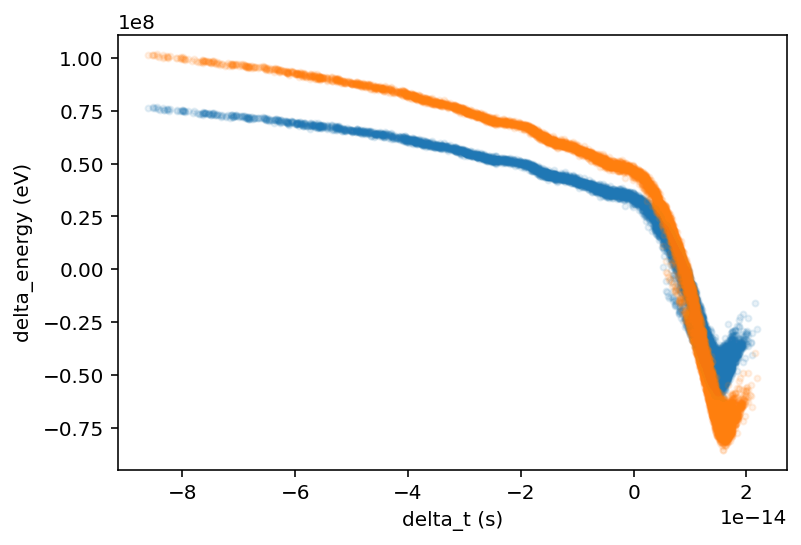

In [27]:
# Compare on the same plot
k1= 'delta_t'
k2 = 'delta_energy'
plt.scatter(P1[k1], P1[k2], marker='.', alpha=0.1)
plt.scatter(P2[k1], P2[k2], marker='.', alpha=0.1)
plt.xlabel(f'{k1} ({P1.units(k1).unitSymbol})')
plt.ylabel(f'{k2} ({P1.units(k2).unitSymbol})')

# Get giant table of bunch stats

In [28]:
import pandas as pd

In [29]:
# Get list of indices
IX = tao.lat_list('*', 'ele.ix_ele')

# Stop before the dump
S_STOP = tao.ele_head('ENDUNDH')['s']

stats = []
for ele in IX:
    d = tao.bunch_params(ele)
    # Skipl ones with no beam
    if d['charge_live'] == 0:
        continue
    
    if d['s'] > S_STOP:
        break
        
    stats.append(d)

df = pd.DataFrame(stats)#.set_index('ix_ele')
df

,beta_x,alpha_x,gamma_x,phi_x,eta_x,etap_x,sigma_x,sigma_p_x,emit_x,norm_emit_x,...,ix_ele,direction,species,location,s,charge_live,n_particle_tot,n_particle_live,n_particle_lost_in_ele,beam_saved
0,1.138081,0.072154,0.883247,0.0,-0.000678,0.000980,0.000046,0.000040,1.837516e-09,4.854533e-07,...,148,1,Electron,Downstream_End,14.241029,2.500000e-10,10000,10000,0,True
1,1.138186,-0.072644,0.883227,0.0,-0.000517,0.000980,0.000046,0.000040,1.837556e-09,4.854641e-07,...,149,1,Electron,Downstream_End,14.404860,2.500000e-10,10000,10000,0,False
2,1.138186,-0.072644,0.883227,0.0,-0.000517,0.000980,0.000046,0.000040,1.837556e-09,4.854641e-07,...,150,1,Electron,Downstream_End,14.404860,2.500000e-10,10000,10000,0,False
3,3.628441,-1.484601,0.883035,0.0,0.001051,0.000980,0.000082,0.000040,1.837956e-09,4.855697e-07,...,151,1,Electron,Downstream_End,16.002790,2.500000e-10,10000,10000,0,False
4,3.628441,-1.484601,0.883035,0.0,0.001051,0.000980,0.000082,0.000040,1.837956e-09,4.855697e-07,...,152,1,Electron,Downstream_End,16.002790,2.500000e-10,10000,10000,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2753,106.622418,-3.776008,0.143105,0.0,0.044591,0.001573,0.000118,0.000004,1.301950e-10,2.809041e-06,...,2901,1,Electron,Downstream_End,1700.921790,2.061000e-10,10000,8244,0,True
2754,129.131299,-4.182019,0.143182,0.0,0.049060,0.001573,0.000130,0.000004,1.301252e-10,2.807537e-06,...,2902,1,Electron,Downstream_End,1703.724965,2.061000e-10,10000,8244,0,False
2755,129.553693,-4.189264,0.143183,0.0,0.049140,0.001573,0.000130,0.000004,1.301240e-10,2.807511e-06,...,2903,1,Electron,Downstream_End,1703.774965,2.061000e-10,10000,8244,0,False
2756,130.036116,-4.197524,0.143185,0.0,0.049231,0.001573,0.000130,0.000004,1.301226e-10,2.807480e-06,...,2904,1,Electron,Downstream_End,1703.831965,2.061000e-10,10000,8244,0,False


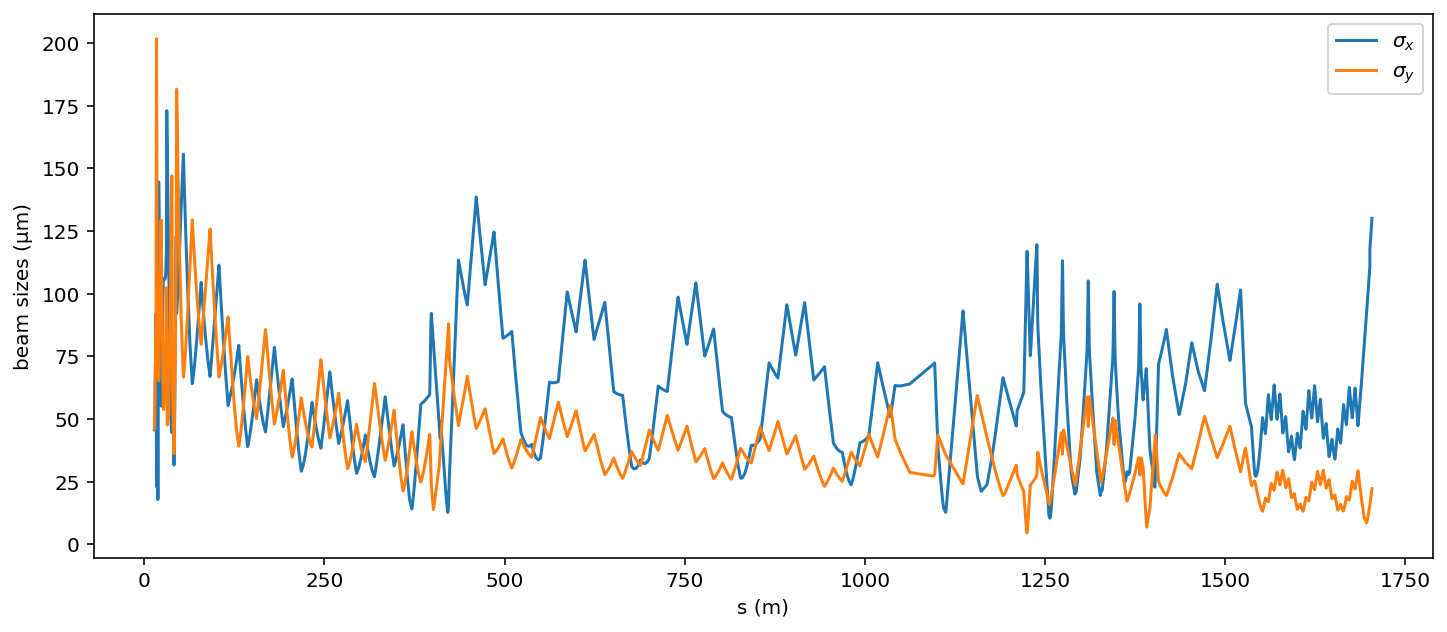

In [30]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(df['s'], df['sigma_x']*1e6, label=r'$\sigma_x$')
plt.plot(df['s'], df['sigma_y']*1e6, label=r'$\sigma_y$')
plt.xlabel('s (m)')
plt.ylabel('beam sizes (µm)')
plt.legend();

In [31]:
# Get an array of where the beam is saved
s_saved = np.array(df[df['beam_saved']]['s'])

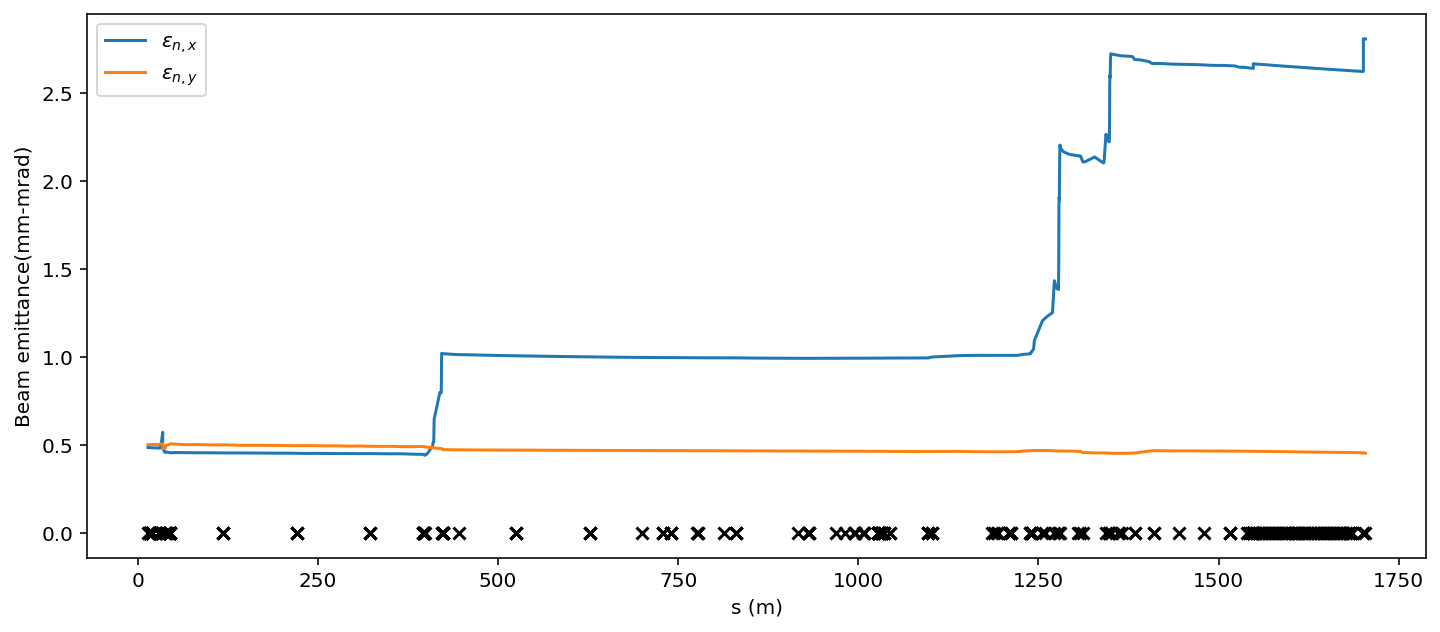

In [32]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(df['s'], df['norm_emit_x']*1e6, label=r'$\epsilon_{n,x}$')
plt.plot(df['s'], df['norm_emit_y']*1e6, label=r'$\epsilon_{n,y}$')
plt.xlabel('s (m)')
plt.ylabel('Beam emittance(mm-mrad)')


# This is where the beam is saved
plt.scatter(s_saved, np.ones(len(s_saved))*0, color = 'black', marker = 'x')


plt.legend();